In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [2]:
if IN_COLAB:
  # Install dependencies
  ! pip install --upgrade pip
  ! pip install czitools

In [3]:
# import the required libraries
from czitools.metadata_tools import czi_metadata as czimd
from czitools.read_tools import read_tools as czird
from czitools.utils import misc
from IPython.display import display, HTML
import dask.array as da
import ipywidgets as widgets

if not IN_COLAB:
    import napari
    from napari.utils.colormaps import Colormap


In [4]:
czifiles = [("CellDivision_T10_Z15_CH2_DCV_small.czi", r"https://github.com/sebi06/czitools/raw/main/data/CellDivision_T10_Z15_CH2_DCV_small.czi"),
            ("CellDivision_T3_Z5_CH2_X240_Y170.czi", r"https://github.com/sebi06/czitools/raw/main/data/CellDivision_T3_Z5_CH2_X240_Y170.czi"),
            ("WP96_4Pos_B4-10_DAPI.czi", r"https://github.com/sebi06/czitools/raw/main/data/WP96_4Pos_B4-10_DAPI.czi"),
            ("w96_A1+A2.czi", r"https://github.com/sebi06/czitools/raw/main/data/w96_A1%2BA2.czi")]

In [11]:
wd = widgets.Select(
    options=czifiles,
    value=r"https://github.com/sebi06/czitools/raw/main/data/CellDivision_T3_Z5_CH2_X240_Y170.czi",
    description='CZI Files:',
    layout={'width': 'max-content'}
)

display(wd)

Select(description='CZI Files:', index=1, layout=Layout(width='max-content'), options=(('CellDivision_T10_Z15_…

In [12]:
selected_file = wd.value

print(f"Selected CZI File {selected_file}")

Selected CZI File https://github.com/sebi06/czitools/raw/main/data/CellDivision_T3_Z5_CH2_X240_Y170.czi


In [13]:
%%capture
# get the complete metadata at once as one big class
mdata = czimd.CziMetadata(selected_file)

# get the CZI metadata dictionary directly from filename
mdict = czimd.create_md_dict_red(mdata, sort=False, remove_none=True)

# convert metadata dictionary to a pandas dataframe
mdframe = misc.md2dataframe(mdict)

2025-08-23 20:02:41,228 - czitools - INFO - FilePath is a valid link. Only pylibCZIrw functionality is available.
2025-08-23 20:02:42,288 - czitools - WARNING - Reading PlaneTable from CZI via a link is not supported yet.


In [14]:
# create a ipywdiget to show the dataframe with the metadata
wd = widgets.Output(layout={"scrollY": "auto", "height": "300px"})

with wd:
    display(HTML(mdframe.to_html()))
display(widgets.VBox(children=[wd]))

In [15]:
# return array with dimension order STCZYX(A)
array6d, mdata= czird.read_6darray(selected_file)

# print the shape of the array etc.
print(f"Shape: {array6d.shape}")
print(f"Dimensions: {array6d.dims}")

for k, v in array6d.attrs.items():
    print(f"{k} :  {v}")

# show dask array structure
if isinstance(array6d, da.Array):
    print(array6d)
else:
    print("Shape:", array6d.shape, "dtype:", array6d.dtype)


2025-08-23 20:02:52,765 - czitools - INFO - FilePath is a valid link. Only pylibCZIrw functionality is available.
2025-08-23 20:02:53,883 - czitools - WARNING - Reading PlaneTable from CZI via a link is not supported yet.
2025-08-23 20:02:54,379 - czitools - INFO - Reading pixel data via network from link location.


Reading 2D planes: 0 2Dplanes [00:00, ? 2Dplanes/s]

Shape: (1, 3, 2, 5, 170, 240)
Dimensions: ('S', 'T', 'C', 'Z', 'Y', 'X')
description :  6D image data from CZI file
source :  https://github.com/sebi06/czitools/raw/main/data/CellDivision_T3_Z5_CH2_X240_Y170.czi
axes :  STCZYX
subset_planes :  {'S': (0, 0), 'T': (0, 2), 'C': (0, 1), 'Z': (0, 4)}
Shape: (1, 3, 2, 5, 170, 240) dtype: uint16


In [19]:
if not IN_COLAB:

    # show in napari (requires napari to be installed!)
    viewer = napari.Viewer()

    # loop over all channels
    for ch in range(0, array6d.sizes["C"]):

        # extract channel subarray
        sub_array = array6d.sel(C=ch)

        # get the scaling factors for that channel and adapt Z-axis scaling
        scalefactors = [1.0] * len(sub_array.shape)
        scalefactors[sub_array.get_axis_num("Z")] = mdata.scale.ratio["zx_sf"]# * 1.00001

        # remove the last scaling factor in case of an RGB image
        if "A" in sub_array.dims:
            # remove the A axis from the scaling factors
            scalefactors.pop(sub_array.get_axis_num("A"))

        # get colors and channel name
        chname = mdata.channelinfo.names[ch]

        # inside the CZI metadata_tools colors are defined as ARGB hexstring
        rgb = "#" + mdata.channelinfo.colors[ch][3:]
        ncmap = Colormap(["#000000", rgb], name="cm_" + chname)

        # add the channel to the viewer
        viewer.add_image(
            sub_array,
            name=chname,
            colormap=ncmap,
            blending="additive",
            scale=scalefactors,
            gamma=0.85,
        )

        # set the axis labels based on the dimensions
        viewer.dims.axis_labels = sub_array.dims

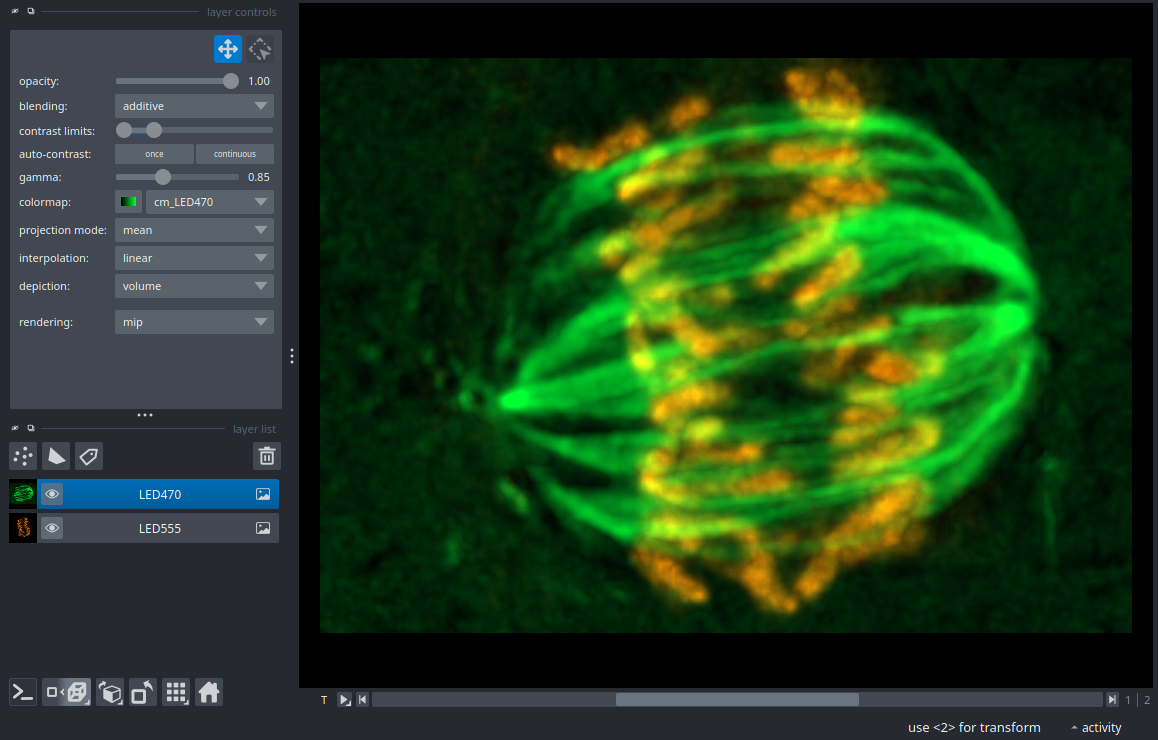

In [20]:
napari.utils.nbscreenshot(viewer)